## Web References

### System

- [How to copy a file without using scp inside an ssh session?](https://superuser.com/questions/291423/how-to-copy-a-file-without-using-scp-inside-an-ssh-session)

### PySpark

- [Complete Machine Learning Project with PySpark MLlib Tutorial](https://www.youtube.com/watch?v=1a7bB1ZcZ3k)
- [The ONLY PySpark Tutorial You Will Ever Need.](https://www.youtube.com/watch?v=cZS5xYYIPzk)
- [PySpark When Otherwise | SQL Case When Usage](https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/)
- [Spark rlike() Working with Regex Matching Examples](https://sparkbyexamples.com/spark/spark-rlike-regex-matching-examples/)
- [spark dataframe drop duplicates and keep first](https://stackoverflow.com/questions/38687212/spark-dataframe-drop-duplicates-and-keep-first)
- [Spark SQL Window functions using plain SQL](https://www.linkedin.com/pulse/spark-sql-window-functions-using-plain-ram-ghadiyaram/)
- [Calculate difference with previous row in PySpark](https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html)
- [forward fill with last observation for a DataFrame](https://stackoverflow.com/questions/36019847/pyspark-forward-fill-with-last-observation-for-a-dataframe)
- [Imputer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html)

### Pandas

- [Pandas resample() tricks you should know for manipulating time-series data](https://towardsdatascience.com/pandas-resample-tricks-you-should-know-for-manipulating-time-series-data-7e9643a7e7f3)
- [Resample with categories in pandas, keep non-numerical columns](https://stackoverflow.com/questions/56001927/resample-with-categories-in-pandas-keep-non-numerical-columns)

### Time Series

- [Time Series Analysis with Spark](https://www.youtube.com/watch?v=tKkneWcAIqU)
- [Time Series Stream Processing with Spark and Cassandra](https://www.youtube.com/watch?v=fBWLzB0FMX4)
- [Spark Basics: Missing Data and Time Series](https://www.youtube.com/watch?v=kvLCxHvL7U0)
- [Spark Resampling, Spark UDFs, Resampling Time Series Data with Spark](https://www.youtube.com/watch?v=uFws-jPywmc)

### Spark ML
- [K Means Clustering using PySpark on Big Data](https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b)
- [K Means Clustering with PySpark hack data](https://www.youtube.com/watch?v=mbYNKM3hdPI)
- [Tutorial : K-Means Clustering On Spark](https://www.data4v.com/tutorial-k-means-clustering-on-spark/)
- [Spark Clustering](https://runawayhorse001.github.io/LearningApacheSpark/clustering.html)
- [How to apply pyspark-mllib-kmeans to categorical variables](https://stackoverflow.com/questions/34700623/how-to-apply-pyspark-mllib-kmeans-to-categorical-variables)

### Anomaly Detection

- [How to Build an Anomaly Detection Engine with Spark, Akka and Cassandra](https://learning.oreilly.com/videos/how-to-build/9781491955253/9781491955253-video244545/)
- [Real Time Detection of Anomalies in the Database Infrastructure using Apache Spark](https://www.youtube.com/watch?v=1IsMMmug5q0)

### Other

- [What is CRISP DM?](https://www.datascience-pm.com/crisp-dm-2/)

### Internet Traffic

- [Data mining approach for predicting the daily Internet data traffic of a smart university](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0176-5)

## Import Libraries

In [1]:
import datetime
import calendar
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, asc, desc, col, expr, lag, isnull, from_unixtime, year, month, dayofmonth, dayofweek, hour, minute
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
import seaborn as sns

## HDFS Preparation

In [2]:
%%bash
#!/bin/bash

# delete the 
if hadoop fs -test -d router; then
    # delete the output directory
    hadoop fs -rm -r router/output

    # create a new output directory
    hadoop fs -mkdir router/output
else
    # create the router directory and upload the input files
    hadoop fs -mkdir router
    hadoop fs -mkdir router/sample
    hadoop fs -put data/bandwidth.csv router/sample/

    hadoop fs -put data/raw router/raw

    # create the output directory
    hadoop fs -mkdir router/output
fi

hadoop fs -ls router/raw | tail

Deleted router/output
-rw-r--r--   3 jfoul001 users     150611 2022-03-12 16:49 router/raw/20220312T1450.csv.gz
-rw-r--r--   3 jfoul001 users     149442 2022-03-12 16:49 router/raw/20220312T1500.csv.gz
-rw-r--r--   3 jfoul001 users     149344 2022-03-12 16:48 router/raw/20220312T1510.csv.gz
-rw-r--r--   3 jfoul001 users     149708 2022-03-12 16:48 router/raw/20220312T1520.csv.gz
-rw-r--r--   3 jfoul001 users     146728 2022-03-12 16:48 router/raw/20220312T1530.csv.gz
-rw-r--r--   3 jfoul001 users     145875 2022-03-12 16:49 router/raw/20220312T1540.csv.gz
-rw-r--r--   3 jfoul001 users     144604 2022-03-12 16:48 router/raw/20220312T1550.csv.gz
-rw-r--r--   3 jfoul001 users     144229 2022-03-12 16:48 router/raw/20220312T1600.csv.gz
-rw-r--r--   3 jfoul001 users     145961 2022-03-12 16:49 router/raw/20220312T1610.csv.gz
-rw-r--r--   3 jfoul001 users     146105 2022-03-12 16:48 router/raw/20220312T1620.csv.gz


## Initialize the Spark Session

In [3]:
spark = SparkSession.builder.appName('cw02').getOrCreate()
spark

Setting default log level to "ERROR".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## I. Data Understanding

Identify, collect, and analyze the data sets that will help accomplish the project goals

### A. Collect Initial Data

In [4]:
#input_path = 'router/sample/bandwidth.csv'
input_path = 'router/raw/'

# read the full batch to process
df_batch = spark.read.csv(input_path, header=False, inferSchema=True) \
    .toDF('direction','interval_length','intervals_saved','ip','interval_start','interval_end','bytes_used')

In [5]:
# drop the intervals saved column
df_batch = df_batch.drop('intervals_saved')
print(f'Row Count: {df_batch.count():,}')

Row Count: 22,794,536


Remove records related to a specific upload or download class. This is done because this information is not relevant to the project, and have an additional column that will complicate data processing.

In [6]:
df_batch_preproc = df_batch.where(df_batch['interval_length'].contains('class_') == False)
print(f'Row Count: {df_batch_preproc.count():,}')

Row Count: 18,640,069


### B. Describe data

Examine the data and document its surface properties like data format, number of records, or field identities.

#### 1. Data Format

In [7]:
df_batch_preproc.printSchema()

root
 |-- direction: string (nullable = true)
 |-- interval_length: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)



In [8]:
print(f'Row Count: {df_batch_preproc.count():,}')

Row Count: 18,640,069


#### 2. Remove Duplicates

Many duplicate records are present in the raw data since the data snapshots overlaps.

In [9]:
# drop duplicates
df_unique = df_batch_preproc.drop_duplicates()
print(f'Row Count: {df_unique.count():,}')

Row Count: 3,420,254


There are duplicates where only the `Bytes Used` field is different due to when the data snapshot was taken.

In [10]:
df_unique = df_unique.groupBy(['direction','interval_length','ip','interval_start','interval_end']) \
    .max('bytes_used') \
    .withColumnRenamed('max(bytes_used)', 'bytes_used')

print(f'Row Count: {df_unique.count():,}')

Row Count: 3,296,392


In [11]:
df_unique.show(5)

+---------+---------------+-------------+--------------+------------+----------+
|direction|interval_length|           ip|interval_start|interval_end|bytes_used|
+---------+---------------+-------------+--------------+------------+----------+
|   upload|            day|     COMBINED|    1628805600|  1628892000|4005707937|
|   upload|         minute|192.168.3.224|    1646678160|  1646678220|         0|
| download|              2|192.168.1.107|    1646677222|  1646677224|         0|
| download|         minute|192.168.3.126|    1646676540|  1646676600|  22500869|
|   upload|              2|192.168.1.136|    1646583220|  1646583222|         0|
+---------+---------------+-------------+--------------+------------+----------+
only showing top 5 rows



### C. Explore data

Dig deeper into the data. Query it, visualize it, and identify relationships among the data.

#### 1. Unique Categories

In [12]:
# if an IP address is stored in the IP column recode it as simply 'IP'
df_interval_type = df_unique.withColumn('interval_type', 
    when(df_unique['ip']
    .rlike('^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'), 'IP')
    .otherwise(df_unique['ip'])
)

df_interval_type.groupBy(['interval_type']).count().toPandas()

,interval_type,count
0,IP,2581139
1,COMBINED,715253


In [13]:
# record count per catergory
df_interval_type.groupBy(['interval_length', 'interval_type']) \
    .count() \
    .orderBy(['interval_length', 'interval_type',], ascending=True) \
    .toPandas()

,interval_length,interval_type,count
0,180,COMBINED,11078
1,2,COMBINED,673209
2,2,IP,2093487
3,7200,COMBINED,1092
4,900,COMBINED,3030
5,900,IP,67068
6,day,COMBINED,760
7,day,IP,4854
8,hour,COMBINED,770
9,hour,IP,21196


#### 2. How many intervals are available for the various categories?

This number should be less as for every interval there could be multiple IP addresses (where `interval_type == 'IP'`).

In [14]:
df_interval_type.drop_duplicates(['direction', 'interval_length', 'interval_type', 'interval_start', 'interval_end']) \
    .groupBy(['interval_length', 'interval_type']) \
    .count() \
    .orderBy(['interval_length', 'interval_type',], ascending=True) \
    .toPandas()

,interval_length,interval_type,count
0,180,COMBINED,11078
1,2,COMBINED,673209
2,2,IP,673359
3,7200,COMBINED,1092
4,900,COMBINED,3030
5,900,IP,3030
6,day,COMBINED,760
7,day,IP,92
8,hour,COMBINED,770
9,hour,IP,770


#### 3. Minute Plot

Group the minute data by interval and show a line plot of the first twho hours for a visual overview of the data.

In [15]:
# get the summarized data
df_interval_bandwidth = df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP')) \
    .groupBy(['interval_start']) \
    .sum('bytes_used') \
    .orderBy(['interval_start'], ascending=True) \
    .withColumnRenamed('sum(bytes_used)', 'bytes_used') \
    .limit(2 * 60) \
    .toPandas()

df_interval_bandwidth.describe()

,bytes_used
count,1.200000e+02
mean,2.216871e+07
std,3.043667e+07
min,4.337154e+06
25%,7.530486e+06
50%,9.770354e+06
75%,1.722035e+07
max,1.445253e+08


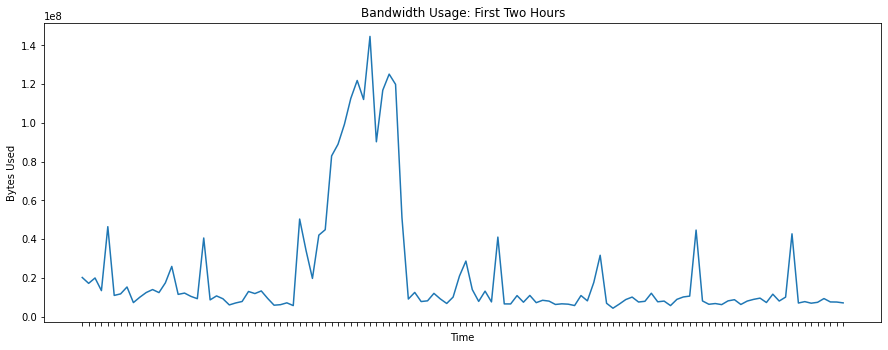

In [16]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_bandwidth,
    x='interval_start',
    y='bytes_used',
    ax=ax
).set(
    title='Bandwidth Usage: First Two Hours',
    ylabel='Bytes Used',
    xlabel='Time',
    xticklabels=[])

plt.show()

#### 4. Number of IP addresses in the last two hours

Notes:

- To count the number of local IP addresses use the `startswith` filter of `192.`
- The dataset contains incomplete intervals where `Interval End == 0` to indicate that the interval was not yet complete when the snapshot was taken.

In [17]:
# the filter on IP is to select only local IP addresses
df_interval_clients = spark.createDataFrame(df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           (df_interval_type['ip'].startswith('192.')) &
           (df_interval_type['interval_end'] > 0)) \
    .drop_duplicates(['ip', 'interval_start', 'interval_end']) \
    .groupBy(['interval_start']) \
    .count() \
    .orderBy(['interval_start'], ascending=True) \
    .tail(2 * 60)) \
    .toPandas()

df_interval_clients.describe()

,count
count,120.000000
mean,12.808333
std,1.117439
min,4.000000
25%,13.000000
50%,13.000000
75%,13.000000
max,14.000000


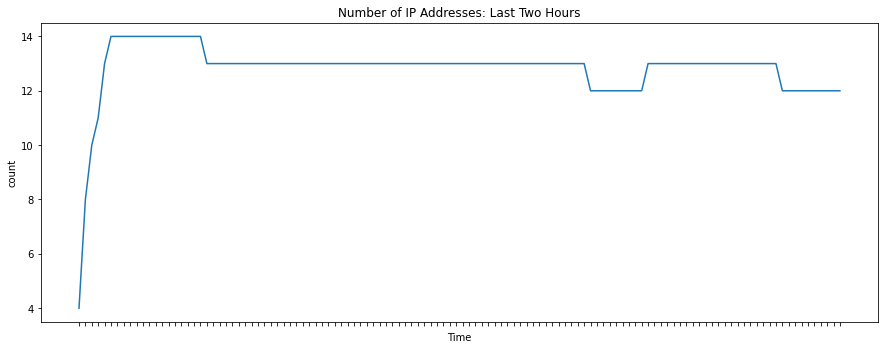

In [18]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_clients,
    x='interval_start',
    y='count',
    ax=ax
).set(
    title='Number of IP Addresses: Last Two Hours',
    xlabel='Time',
    xticklabels=[])

plt.show()

### D. Verify data quality

#### 1. Select only data by minute with an IP address

In [19]:
df_minute = df_interval_type \
    .where((df_interval_type['interval_length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           ((df_interval_type['interval_end'] > 0))) 

print(f'Row Count: {df_minute.count():,}')

Row Count: 355,604


In [20]:
# verify that no null values are present in the dataset
assert df_minute.count() == df_minute.dropna().count()

In [21]:
# save the dataset to HDFS
df_minute.write.parquet('router/output/minute', mode='overwrite', compression='gzip')

#### 2. Find data gaps

In [22]:
# get the unique intervals
df_unique_intervals = df_minute \
    .drop_duplicates(['interval_start', 'interval_end']) \
    .drop('direction') \
    .drop('interval_length') \
    .drop('interval_end') \
    .drop('ip') \
    .drop('bytes_used') \
    .drop('interval_type')

interval_window = Window.partitionBy().orderBy('interval_start')

# add the previous interval start value
df_prev = df_unique_intervals \
    .withColumn('prev_interval_start', lag('interval_start', 1).over(interval_window))

# calculate the difference
df_prev = df_prev \
    .withColumn('diff', when(isnull(df_prev.prev_interval_start), 0) \
                       .otherwise(df_prev['interval_start'] - df_prev['prev_interval_start']))


df_prev.limit(10).toPandas()


,interval_start,prev_interval_start,diff
0,1646430900,None,0.0
1,1646430960,1646430900,60.0
2,1646431020,1646430960,60.0
3,1646431080,1646431020,60.0
4,1646431140,1646431080,60.0
5,1646431200,1646431140,60.0
6,1646431260,1646431200,60.0
7,1646431320,1646431260,60.0
8,1646431380,1646431320,60.0
9,1646431440,1646431380,60.0


In [23]:
df_prev.select('diff').summary().toPandas()

,summary,diff
0,count,11180
1,mean,60.021466905187836
2,stddev,2.8935067075317744
3,min,0.0
4,25%,60.0
5,50%,60.0
6,75%,60.0
7,max,360.0


In [24]:
df_prev.where('diff > 60').toPandas()

,interval_start,prev_interval_start,diff
0,1646574900,1646574540,360.0


## II. Data Preparation

### A. Select Data

In [25]:
# load the dataset form the previous section
df_source = spark.read.parquet('router/output/minute')
print(f'Row Count: {df_source.count():,}')

Row Count: 355,604


In [26]:
df_source.printSchema()

root
 |-- direction: string (nullable = true)
 |-- interval_length: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)
 |-- interval_type: string (nullable = true)



### B. Clean Data

#### 1. Remove the `interval_type` and `interval_length` columns

In [27]:
df_minute = df_source \
    .drop('interval_type') \
    .drop('interval_length')

df_minute.limit(5).toPandas()

,direction,ip,interval_start,interval_end,bytes_used
0,upload,192.168.3.185,1646503620,1646503680,5010
1,upload,192.168.3.188,1646763420,1646763480,0
2,download,192.168.3.185,1646524080,1646524140,534
3,upload,192.168.3.103,1646690400,1646690460,0
4,upload,192.168.1.160,1646552460,1646552520,0


#### 2. Add a `time` columns from the interval start end end epoch

In [28]:
# convert epoch columns to datetime
df_minute = df_minute \
    .withColumn('interval_start_time', from_unixtime(df_minute['interval_start'])) \
    .withColumn('interval_end_time', from_unixtime(df_minute['interval_end']))

df_minute.limit(5).toPandas()

,direction,ip,interval_start,interval_end,bytes_used,interval_start_time,interval_end_time
0,upload,192.168.3.185,1646503620,1646503680,5010,2022-03-05 18:07:00,2022-03-05 18:08:00
1,upload,192.168.3.188,1646763420,1646763480,0,2022-03-08 18:17:00,2022-03-08 18:18:00
2,download,192.168.3.185,1646524080,1646524140,534,2022-03-05 23:48:00,2022-03-05 23:49:00
3,upload,192.168.3.103,1646690400,1646690460,0,2022-03-07 22:00:00,2022-03-07 22:01:00
4,upload,192.168.1.160,1646552460,1646552520,0,2022-03-06 07:41:00,2022-03-06 07:42:00


### C. Construct Data

#### 1. Add Date Features

In [29]:
df_minute_date = df_minute \
    .withColumn('year', year(df_minute['interval_start_time'])) \
    .withColumn('month', month(df_minute['interval_start_time'])) \
    .withColumn('day', dayofmonth(df_minute['interval_start_time'])) \
    .withColumn('day_of_week', dayofweek(df_minute['interval_start_time'])) \
    .withColumn('hour', hour(df_minute['interval_start_time'])) \
    .withColumn('minute', minute(df_minute['interval_start_time']))

df_minute_date.limit(5).toPandas()

,direction,ip,interval_start,interval_end,bytes_used,interval_start_time,interval_end_time,year,month,day,day_of_week,hour,minute
0,upload,192.168.3.185,1646503620,1646503680,5010,2022-03-05 18:07:00,2022-03-05 18:08:00,2022,3,5,7,18,7
1,upload,192.168.3.188,1646763420,1646763480,0,2022-03-08 18:17:00,2022-03-08 18:18:00,2022,3,8,3,18,17
2,download,192.168.3.185,1646524080,1646524140,534,2022-03-05 23:48:00,2022-03-05 23:49:00,2022,3,5,7,23,48
3,upload,192.168.3.103,1646690400,1646690460,0,2022-03-07 22:00:00,2022-03-07 22:01:00,2022,3,7,2,22,0
4,upload,192.168.1.160,1646552460,1646552520,0,2022-03-06 07:41:00,2022-03-06 07:42:00,2022,3,6,1,7,41


#### 2. VLAN Feature

In [30]:
df_minute_vlan_all = df_minute_date \
    .withColumn('vlan', when(df_minute_date['ip'].startswith('192.168.1'), 'private') \
                        .when(df_minute_date['ip'].startswith('192.168.3'), 'tenants') \
                        .when(df_minute_date['ip'].startswith('192.168'), 'other') \
                        .otherwise('internal'))

df_minute_vlan_all.limit(5).toPandas()

,direction,ip,interval_start,interval_end,bytes_used,interval_start_time,interval_end_time,year,month,day,day_of_week,hour,minute,vlan
0,upload,192.168.3.185,1646503620,1646503680,5010,2022-03-05 18:07:00,2022-03-05 18:08:00,2022,3,5,7,18,7,tenants
1,upload,192.168.3.188,1646763420,1646763480,0,2022-03-08 18:17:00,2022-03-08 18:18:00,2022,3,8,3,18,17,tenants
2,download,192.168.3.185,1646524080,1646524140,534,2022-03-05 23:48:00,2022-03-05 23:49:00,2022,3,5,7,23,48,tenants
3,upload,192.168.3.103,1646690400,1646690460,0,2022-03-07 22:00:00,2022-03-07 22:01:00,2022,3,7,2,22,0,tenants
4,upload,192.168.1.160,1646552460,1646552520,0,2022-03-06 07:41:00,2022-03-06 07:42:00,2022,3,6,1,7,41,private


In [31]:
# summary of networks in the dataset
df_distinct_ip = df_minute_vlan_all \
    .select('ip', 'vlan') \
    .distinct()

df_distinct_ip.groupBy('vlan').count().toPandas()

,vlan,count
0,tenants,24
1,internal,2
2,private,11


- `197.95.152.171` is the public IP of the switch.
- `172.17.0.2` is the internal IP address of the router.

In [32]:
df_distinct_ip.where('vlan == "internal"').toPandas()

,ip,vlan
0,197.94.242.117,internal
1,172.17.0.2,internal


In [33]:
# how much data are used by the vlan categories
df_summary_vlan = df_minute_vlan_all \
    .groupBy('direction', 'vlan') \
    .sum('bytes_used') \
    .orderBy('direction', 'vlan') \

df_summary_vlan.show()

+---------+--------+---------------+
|direction|    vlan|sum(bytes_used)|
+---------+--------+---------------+
| download|internal|      134532641|
| download| private|    93240231430|
| download| tenants|   155401157383|
|   upload|internal|       59844806|
|   upload| private|    18620813619|
|   upload| tenants|    23002695096|
+---------+--------+---------------+



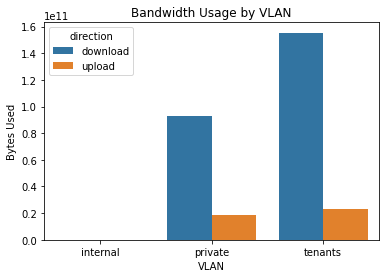

In [34]:
# plot the vlan summary
sns.barplot(
    data=df_summary_vlan.toPandas(),
    x='vlan',
    y='sum(bytes_used)',
    hue='direction'
).set(
    title='Bandwidth Usage by VLAN',
    ylabel='Bytes Used',
    xlabel='VLAN'
)

plt.show()

In [35]:
# remove the internal ip addresses form the dataset
df_minute_vlan = df_minute_vlan_all \
    .where('vlan != "internal"')

print(f'Row Count: {df_minute_vlan.count():,}')

Row Count: 331,048


##### Daily Bandwidth Usage

In [36]:
# get the summary data
df_daily_summary = df_minute_vlan \
    .groupBy('year', 'month', 'day', 'vlan') \
    .sum('bytes_used') \
    .orderBy('year', 'month', 'day', 'vlan').toPandas()

df_daily_summary.head()

,year,month,day,vlan,sum(bytes_used)
0,2022,3,4,private,138364651
1,2022,3,4,tenants,2518310329
2,2022,3,5,private,13337844087
3,2022,3,5,tenants,21974716480
4,2022,3,6,private,9746012979


In [37]:
# add a date column
df_daily_summary['date'] = pd.to_datetime(df_daily_summary[['year', 'month', 'day']])
df_daily_summary.drop(columns=['year', 'month', 'day'], inplace=True)

df_daily_summary.head()

,vlan,sum(bytes_used),date
0,private,138364651,2022-03-04
1,tenants,2518310329,2022-03-04
2,private,13337844087,2022-03-05
3,tenants,21974716480,2022-03-05
4,private,9746012979,2022-03-06


In [38]:
# resample the data to fill gaps if present
df_daily_summary_resampled = df_daily_summary \
    .set_index('date') \
    .groupby('vlan') \
    .resample('D') \
    .sum() \
    .ffill() \
    .reset_index()

# add a gigabytes column
df_daily_summary_resampled['gigabytes'] = df_daily_summary_resampled['sum(bytes_used)'] / 1e9
#df_daily_summary_resampled.sort_values('vlan', inplace=True)

df_daily_summary_resampled.head(10)

,vlan,date,sum(bytes_used),gigabytes
0,private,2022-03-04,138364651,0.138365
1,private,2022-03-05,13337844087,13.337844
2,private,2022-03-06,9746012979,9.746013
3,private,2022-03-07,12818470359,12.818470
4,private,2022-03-08,9636907707,9.636908
5,private,2022-03-09,9629446249,9.629446
6,private,2022-03-10,6903323581,6.903324
7,private,2022-03-11,15164976111,15.164976
8,private,2022-03-12,34485699325,34.485699
9,tenants,2022-03-04,2518310329,2.518310


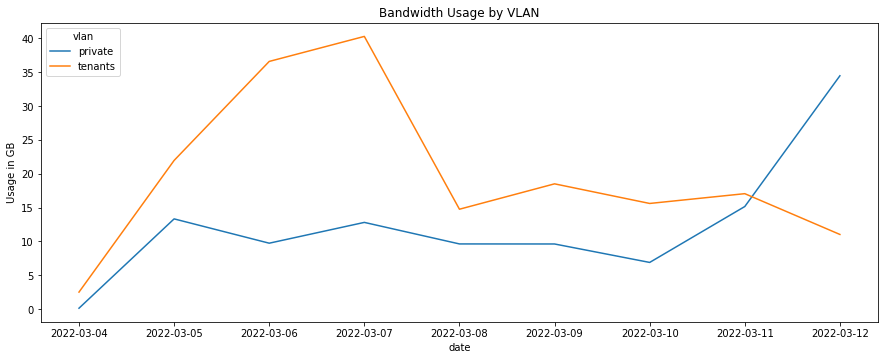

In [39]:
# configure the plot
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

# get x tick labels
x_dates = df_daily_summary_resampled['date'].dt.strftime('%Y-%m-%d').sort_values().unique()

sns.lineplot(
    data=df_daily_summary_resampled,
    x='date',
    y='gigabytes',
    hue='vlan',
    ax=ax
).set(
    title='Bandwidth Usage by VLAN',
    ylabel='Usage in GB',
    xticks=df_daily_summary_resampled.date.unique()
)

plt.show()

##### Summarize by IP and total bytes used

In [40]:
# get the summarized data
df_total_usage = df_minute_vlan \
    .select('IP', 'vlan', 'bytes_used') \
    .groupBy('IP', 'vlan')\
    .sum() \
    .sort('sum(bytes_used)', ascending=False) \
    .toPandas()

df_total_usage['gigabytes'] = df_total_usage['sum(bytes_used)'] / 1e9
df_total_usage.head(10)

,IP,vlan,sum(bytes_used),gigabytes
0,192.168.1.189,private,52698744908,52.698745
1,192.168.3.126,tenants,46972916478,46.972916
2,192.168.3.185,tenants,39075551368,39.075551
3,192.168.1.108,private,38643122930,38.643123
4,192.168.3.224,tenants,18483458791,18.483459
5,192.168.3.111,tenants,16920034700,16.920035
6,192.168.3.103,tenants,15230307004,15.230307
7,192.168.3.125,tenants,12955777400,12.955777
8,192.168.1.186,private,10383105416,10.383105
9,192.168.1.142,private,6071921750,6.071922


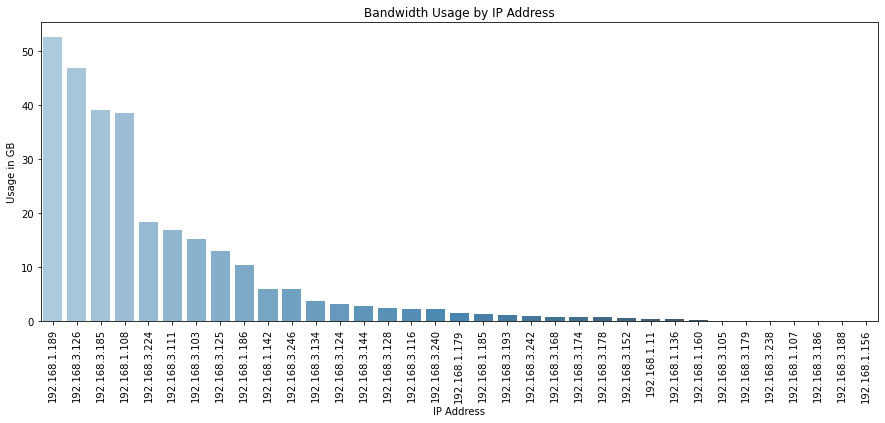

In [41]:
# plot the results
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(
    data=df_total_usage,
    x='IP',
    y='gigabytes',
    palette='Blues_d',
    ax=ax
).set(
    title='Bandwidth Usage by IP Address',
    ylabel='Usage in GB',
    xlabel='IP Address'
)

ax.tick_params(axis='x', rotation=90)
plt.show()

##### Show Daily usage for a visitor

The IP address `192.168.3.193` is of a known vistor cellphone. Visualize the daily usage data for this IP address.

In [42]:
# get the summary from the spark dataframe
df_visitor = df_minute_vlan \
    .where('IP == "192.168.3.193"') \
    .groupBy('year', 'month', 'day') \
    .sum('bytes_used') \
    .withColumnRenamed('sum(bytes_used)', 'bytes_used') \
    .withColumn('date', expr("make_date(year, month, day)")) \
    .orderBy('date') \
    .toPandas()

In [43]:
# prepare the pandas dataframe for plotting
df_visitor['date'] = pd.to_datetime(df_visitor['date'])

df_visitor = df_visitor \
    .set_index('date') \
    .bytes_used \
    .resample('D') \
    .sum() \
    .reset_index()

In [44]:
df_visitor['connected'] = df_visitor['bytes_used'] > 0

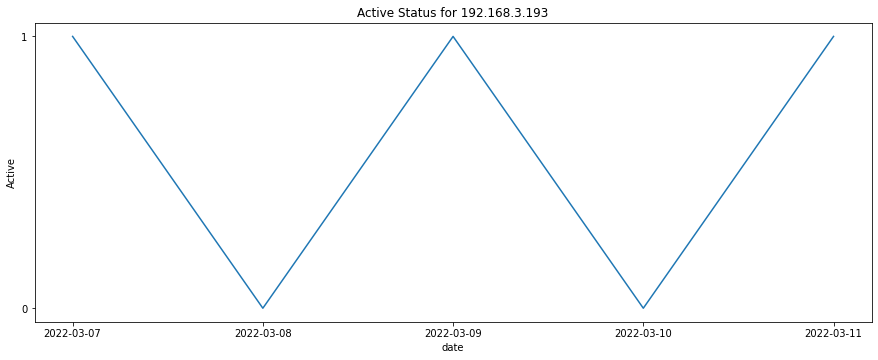

In [45]:
# visualize the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_visitor,
    x='date',
    y='connected',
    ax=ax
).set(
    title='Active Status for 192.168.3.193',
    ylabel='Active',
    xticks=df_visitor.date.unique(),
    yticks=[True, False]
)

plt.show()

#### 3. Part of day feature

Split the total usage into the following parts of the day.

|Part     |Start|End  |
|---------|-----|-----|
|Morning  |5:00 |11:59|
|Afternoon|12:00|17:59|
|Evening  |18:00|23:59|
|Night    |0:00 |4:59 |

In [46]:
df_minute_vlan = df_minute_vlan \
    .withColumn('part_of_day',
         when( (col('hour') >= 5) & (col('hour') < 12), 'morning') \
        .when( (col('hour') >= 12) & (col('hour') < 18), 'afternoon') \
        .when( (col('hour') >= 18) & (col('hour') <= 23) & (col('minute') <= 59), 'evening') \
        .when( (col('hour') >= 0) & (col('hour') < 5), 'night') \
        .otherwise(None))

df_minute_vlan.limit(20).toPandas()

,direction,ip,interval_start,interval_end,bytes_used,interval_start_time,interval_end_time,year,month,day,day_of_week,hour,minute,vlan,part_of_day
0,upload,192.168.3.185,1646503620,1646503680,5010,2022-03-05 18:07:00,2022-03-05 18:08:00,2022,3,5,7,18,7,tenants,evening
1,upload,192.168.3.188,1646763420,1646763480,0,2022-03-08 18:17:00,2022-03-08 18:18:00,2022,3,8,3,18,17,tenants,evening
2,download,192.168.3.185,1646524080,1646524140,534,2022-03-05 23:48:00,2022-03-05 23:49:00,2022,3,5,7,23,48,tenants,evening
3,upload,192.168.3.103,1646690400,1646690460,0,2022-03-07 22:00:00,2022-03-07 22:01:00,2022,3,7,2,22,0,tenants,evening
4,upload,192.168.1.160,1646552460,1646552520,0,2022-03-06 07:41:00,2022-03-06 07:42:00,2022,3,6,1,7,41,private,morning
5,upload,192.168.1.142,1647074280,1647074340,11799,2022-03-12 08:38:00,2022-03-12 08:39:00,2022,3,12,7,8,38,private,morning
6,download,192.168.3.242,1646955120,1646955180,25700,2022-03-10 23:32:00,2022-03-10 23:33:00,2022,3,10,5,23,32,tenants,evening
7,upload,192.168.1.11,1646565420,1646565480,5324,2022-03-06 11:17:00,2022-03-06 11:18:00,2022,3,6,1,11,17,private,morning
8,upload,192.168.1.179,1646656260,1646656320,16893,2022-03-07 12:31:00,2022-03-07 12:32:00,2022,3,7,2,12,31,private,afternoon
9,download,192.168.3.134,1646458560,1646458620,76,2022-03-05 05:36:00,2022-03-05 05:37:00,2022,3,5,7,5,36,tenants,morning


In [47]:
df_minute_vlan \
    .groupBy('part_of_day') \
    .sum('bytes_used') \
    .sort('sum(bytes_used)', ascending=False) \
    .toPandas()

,part_of_day,sum(bytes_used)
0,afternoon,116015529880
1,morning,95083708006
2,evening,56610383451
3,night,22555276191


#### 3. Rolling Blackouts

South Africa is in an ongoing energy crisis starting in 2007, and implements rolling blackouts to prevent complete destabilizing of the national grid which will result in a nationwide blackout. The government refers to this as "load shedding".

When there is "load shedding" in the area where the network under study is located, all the tenant access points are down for the entire duration of the blackout. From the data collected we can therfore clearly identify these periods by the drastic drop in connected clients.

In [48]:
# get the summarized data
df_connected = df_minute_vlan \
    .groupBy('ip', 'year', 'month', 'day', 'hour') \
    .sum('bytes_used') \
    .withColumnRenamed('sum(bytes_used)', 'bytes_used') \
    .groupBy('year', 'month', 'day', 'hour') \
    .count() \
    .toPandas()

df_connected.head(3)

,year,month,day,hour,count
0,2022,3,8,4,20
1,2022,3,8,15,5
2,2022,3,10,0,15


In [49]:
# perpare the data for plotting
df_connected['date'] = pd.to_datetime(df_connected[['year', 'month', 'day', 'hour']])
df_connected_resample = df_connected.drop(columns=['year', 'month', 'day', 'hour'])

df_connected_resample = df_connected_resample \
    .set_index('date') \
    .resample('H') \
    .sum() \
    .reset_index() \
    .sort_values('date', ascending=True)

df_connected_resample.head()

,date,count
0,2022-03-04 21:00:00,19
1,2022-03-04 22:00:00,20
2,2022-03-04 23:00:00,20
3,2022-03-05 00:00:00,20
4,2022-03-05 01:00:00,20


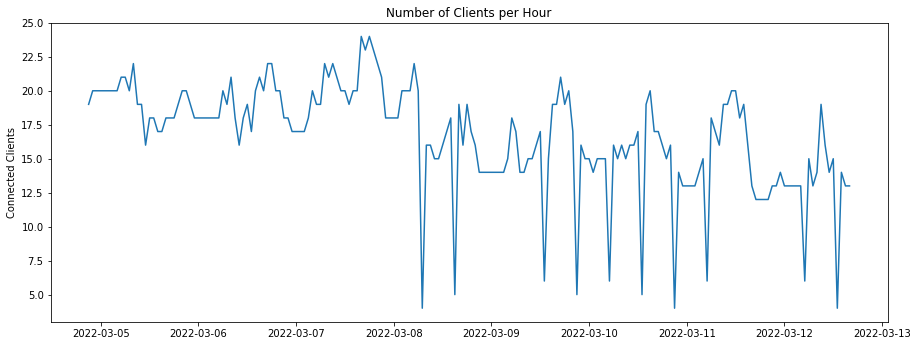

In [50]:
# plot the results
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_connected_resample,
    x='date',
    y='count',
    ax=ax
).set(
    title='Number of Clients per Hour',
    xlabel='',
    ylabel='Connected Clients'
)

plt.show()

#### 4. Create Features for each IP Address

In [51]:
df_minute_vlan.printSchema()

root
 |-- direction: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- interval_start: string (nullable = true)
 |-- interval_end: integer (nullable = true)
 |-- bytes_used: long (nullable = true)
 |-- interval_start_time: string (nullable = true)
 |-- interval_end_time: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- vlan: string (nullable = false)
 |-- part_of_day: string (nullable = true)



In [52]:
# create the base users table
df_users = df_minute_vlan \
    .select('IP', 'vlan', 'bytes_used') \
    .groupBy('IP', 'vlan') \
    .sum() \
    .withColumnRenamed('sum(bytes_used)', 'total_bytes') \
    .sort('IP', ascending=False).toPandas()

print(f'Row Count: {df_users.shape[0]:,}')

Row Count: 35


In [53]:
# calculate the download bytes used
df_users_download = df_minute_vlan \
    .select('IP', 'bytes_used') \
    .where('direction == "download"') \
    .groupBy('IP') \
    .sum() \
    .withColumnRenamed('sum(bytes_used)', 'dowload_bytes') \
    .sort('IP', ascending=False).toPandas()

df_users = df_users.merge(df_users_download, on='IP', how='left')
df_users.head()

,IP,vlan,total_bytes,dowload_bytes
0,192.168.3.246,tenants,6003659108,4339881106
1,192.168.3.242,tenants,983331814,902397036
2,192.168.3.240,tenants,2267423179,1843090457
3,192.168.3.238,tenants,71774178,64192201
4,192.168.3.224,tenants,18483458791,17983850483


In [54]:
# calculate the upload bytes used
df_users_upload = df_minute_vlan \
    .select('IP', 'bytes_used') \
    .where('direction == "upload"') \
    .groupBy('IP') \
    .sum() \
    .withColumnRenamed('sum(bytes_used)', 'upload_bytes') \
    .sort('IP', ascending=False).toPandas()

df_users = df_users.merge(df_users_upload, on='IP', how='left')
df_users.head()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes
0,192.168.3.246,tenants,6003659108,4339881106,1663778002
1,192.168.3.242,tenants,983331814,902397036,80934778
2,192.168.3.240,tenants,2267423179,1843090457,424332722
3,192.168.3.238,tenants,71774178,64192201,7581977
4,192.168.3.224,tenants,18483458791,17983850483,499608308


##### Bandwidth usage by day of week

In [55]:
list(calendar.day_name)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [56]:
def get_dayofweek_usage(df_source, dayofweek):
    """
    Get the usage for a specific day of the week

    Parameters
    ----------
    df_source : pySpark dataframe
        The source dataframe
    dayofweek : int
        The day of the week to get the usage for

    Returns
    -------
    df_dayofweek : pySpark dataframe
        The dataframe with the day of the week usage
    """
    day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    day_name = day_names[dayofweek - 1]

    df_dayofweek_usage = df_source \
        .select('IP', 'bytes_used') \
        .where(f'day_of_week == "{dayofweek}"') \
        .groupBy('IP') \
        .avg() \
        .withColumnRenamed('avg(bytes_used)', f'{day_name}_avg_bytes') \
        .sort('IP', ascending=False).toPandas()

    # change the average bytes to an integer
    df_dayofweek_usage[f'{day_name}_avg_bytes'] = \
        df_dayofweek_usage[f'{day_name}_avg_bytes'].astype(int)

    return df_dayofweek_usage

In [57]:
# calculate the average usage for each day of the week
for i in range(0, 7):
    df_dayofweek_usage = get_dayofweek_usage(df_minute_vlan, i+1)
    df_users = df_users.merge(df_dayofweek_usage, on='IP', how='left')

df_users.head()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Sunday_avg_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes
0,192.168.3.246,tenants,6003659108,4339881106,1663778002,884371.0,731149.0,686591.0,NaN,NaN,132844.0,1143805.0
1,192.168.3.242,tenants,983331814,902397036,80934778,110405.0,15476.0,70635.0,69328.0,23617.0,18784.0,38915.0
2,192.168.3.240,tenants,2267423179,1843090457,424332722,12195.0,25176.0,336888.0,341015.0,11545.0,87702.0,288617.0
3,192.168.3.238,tenants,71774178,64192201,7581977,NaN,NaN,NaN,NaN,NaN,292955.0,NaN
4,192.168.3.224,tenants,18483458791,17983850483,499608308,NaN,9517041.0,24160.0,2962873.0,2897.0,3705666.0,NaN


In [58]:
# replace the NaN values with 0
df_users.fillna(0, inplace=True)
df_users.head()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Sunday_avg_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes
0,192.168.3.246,tenants,6003659108,4339881106,1663778002,884371.0,731149.0,686591.0,0.0,0.0,132844.0,1143805.0
1,192.168.3.242,tenants,983331814,902397036,80934778,110405.0,15476.0,70635.0,69328.0,23617.0,18784.0,38915.0
2,192.168.3.240,tenants,2267423179,1843090457,424332722,12195.0,25176.0,336888.0,341015.0,11545.0,87702.0,288617.0
3,192.168.3.238,tenants,71774178,64192201,7581977,0.0,0.0,0.0,0.0,0.0,292955.0,0.0
4,192.168.3.224,tenants,18483458791,17983850483,499608308,0.0,9517041.0,24160.0,2962873.0,2897.0,3705666.0,0.0


##### Visualize the top 10 to see if they will be separable

In [59]:
# create a dataframe suitable for creating the plot
df_day_plot = df_users \
    .rename(columns=lambda x: x.replace('_avg_bytes', '')) \
    .sort_values('total_bytes', ascending=False) \
    .head(10)

df_day_plot = df_day_plot.melt(
    id_vars=list(df_users.columns)[:-7], 
    var_name='day_of_week', 
    value_name='avg_bytes')

df_day_plot.sample(n=5, random_state=5)

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,day_of_week,avg_bytes
34,192.168.3.224,tenants,18483458791,17983850483,499608308,Wednesday,2962873.0
48,192.168.1.186,private,10383105416,7417493518,2965611898,Thursday,1570980.0
28,192.168.1.186,private,10383105416,7417493518,2965611898,Tuesday,1639463.0
67,192.168.3.125,tenants,12955777400,11922464304,1033313096,Saturday,1372420.0
10,192.168.1.189,private,52698744908,39719530830,12979214078,Monday,725043.0


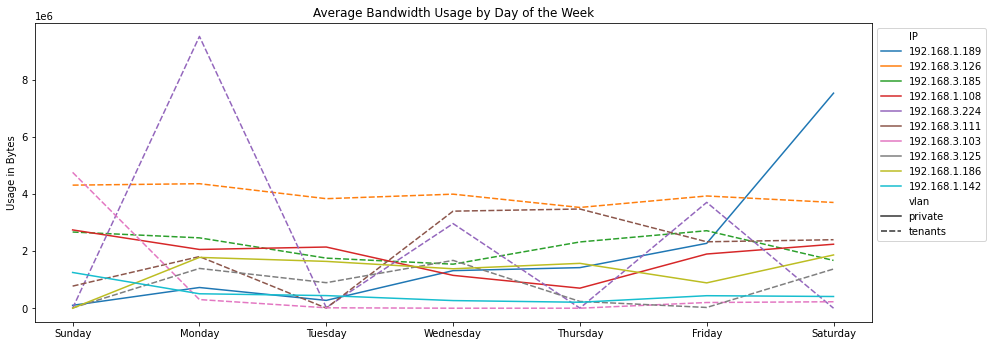

In [60]:

fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_day_plot,
    x='day_of_week',
    y='avg_bytes',
    hue='IP',
    style='vlan',
    ax=ax
).set(
    title='Average Bandwidth Usage by Day of the Week',
    xlabel='',
    ylabel='Usage in Bytes')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


##### Add number of days connected

Visitors are not connected everyday, thus an additional feature that might be useful is a count on each day of the week the user was connected.

In [61]:
df_minute_vlan.limit(3).toPandas()

,direction,ip,interval_start,interval_end,bytes_used,interval_start_time,interval_end_time,year,month,day,day_of_week,hour,minute,vlan,part_of_day
0,upload,192.168.3.185,1646503620,1646503680,5010,2022-03-05 18:07:00,2022-03-05 18:08:00,2022,3,5,7,18,7,tenants,evening
1,upload,192.168.3.188,1646763420,1646763480,0,2022-03-08 18:17:00,2022-03-08 18:18:00,2022,3,8,3,18,17,tenants,evening
2,download,192.168.3.185,1646524080,1646524140,534,2022-03-05 23:48:00,2022-03-05 23:49:00,2022,3,5,7,23,48,tenants,evening


In [62]:
part_of_day = 'morning'

df_minute_vlan \
    .where(f'part_of_day == "{part_of_day}"') \
    .groupBy('IP', 'year', 'month', 'day') \
    .count() \
    .groupBy('IP') \
    .count() \
    .withColumnRenamed('count', f'{part_of_day}') \
    .sort('IP', ascending=False).toPandas()        

,IP,morning
0,192.168.3.246,3
1,192.168.3.242,8
2,192.168.3.240,8
3,192.168.3.238,1
4,192.168.3.224,5
5,192.168.3.193,3
6,192.168.3.188,8
7,192.168.3.186,1
8,192.168.3.185,8
9,192.168.3.179,3


##### Time of day date

Split the total usage into the following parts of the day.

|Part|Start|End|
|----|-----|---|
|Morning|5:00|11:59|
|Afternoon|12:00|17:59|
|Evening|18:00|23:59|
|Night|0:00|4:59|

In [63]:
def get_part_of_day_usage(df_source, part_of_day):
    """
    Get the usage for a specific day of the week

    Parameters
    ----------
    df_source : pySpark dataframe
        The source dataframe
    part_of_day : str
        The part of the day to get the usage for

    Returns
    -------
    df_part_of_day : pySpark dataframe
        The dataframe with the part of the day usage
    """
    df_usage = df_minute_vlan \
        .where(f'part_of_day == "{part_of_day}"') \
        .select('IP', 'bytes_used') \
        .groupBy('IP') \
        .avg() \
        .withColumnRenamed('avg(bytes_used)', f'{part_of_day}_avg_bytes') \
        .sort('IP', ascending=False).toPandas()

    # change the average bytes to an integer
    df_usage[f'{part_of_day}_avg_bytes'] = \
        df_usage[f'{part_of_day}_avg_bytes'].astype(int)

    return df_usage

In [64]:
# calculate the average usage for each day of the week
for part_of_day in ['morning', 'afternoon', 'evening', 'night']:
    df_usage = get_part_of_day_usage(df_minute_vlan, part_of_day) 
    df_users = df_users.merge(df_usage, on='IP', how='left')

# replace the NaN values with 0
df_users.fillna(0, inplace=True)
df_users.head()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Sunday_avg_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes,morning_avg_bytes,afternoon_avg_bytes,evening_avg_bytes,night_avg_bytes
0,192.168.3.246,tenants,6003659108,4339881106,1663778002,884371.0,731149.0,686591.0,0.0,0.0,132844.0,1143805.0,1337523.0,868312.0,1269798.0,313359.0
1,192.168.3.242,tenants,983331814,902397036,80934778,110405.0,15476.0,70635.0,69328.0,23617.0,18784.0,38915.0,72449.0,23792.0,74951.0,15624.0
2,192.168.3.240,tenants,2267423179,1843090457,424332722,12195.0,25176.0,336888.0,341015.0,11545.0,87702.0,288617.0,57422.0,82548.0,402690.0,67722.0
3,192.168.3.238,tenants,71774178,64192201,7581977,0.0,0.0,0.0,0.0,0.0,292955.0,0.0,305414.0,168.0,0.0,0.0
4,192.168.3.224,tenants,18483458791,17983850483,499608308,0.0,9517041.0,24160.0,2962873.0,2897.0,3705666.0,0.0,10321067.0,764764.0,9914.0,24955.0


## III. Modeling

### 1. Clustering Users

##### Select the data to use for clustering

In [65]:
# get the dataframe to perform the clustering on
df_clustering = spark.createDataFrame(df_users)
df_clustering.printSchema()

root
 |-- IP: string (nullable = true)
 |-- vlan: string (nullable = true)
 |-- total_bytes: long (nullable = true)
 |-- dowload_bytes: long (nullable = true)
 |-- upload_bytes: long (nullable = true)
 |-- Sunday_avg_bytes: double (nullable = true)
 |-- Monday_avg_bytes: double (nullable = true)
 |-- Tuesday_avg_bytes: double (nullable = true)
 |-- Wednesday_avg_bytes: double (nullable = true)
 |-- Thursday_avg_bytes: double (nullable = true)
 |-- Friday_avg_bytes: double (nullable = true)
 |-- Saturday_avg_bytes: double (nullable = true)
 |-- morning_avg_bytes: double (nullable = true)
 |-- afternoon_avg_bytes: double (nullable = true)
 |-- evening_avg_bytes: double (nullable = true)
 |-- night_avg_bytes: double (nullable = true)



In [66]:
df_clustering.describe().toPandas()

,summary,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Sunday_avg_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes,morning_avg_bytes,afternoon_avg_bytes,evening_avg_bytes,night_avg_bytes
0,count,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
1,mean,None,None,8.293282786514286E9,7.1040396803714285E9,1.189243106142857E9,690063.6571428571,861802.5142857142,565534.0857142857,759869.0857142857,451769.82857142854,631738.5714285715,728254.6571428571,966466.3142857143,1219129.2571428572,698893.8571428572,236795.3142857143
2,stddev,None,None,1.421034909684499E10,1.2236674519597641E10,2.975695516201076E9,1424537.6451758766,1788692.100355623,914566.1408671704,1369961.1147528405,925851.8372835804,1107612.5310205913,1471252.746263816,1993875.3030375408,1907874.433712313,1240210.0247311802,669503.5716158639
3,min,192.168.1.107,private,140908,81499,59409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,192.168.3.246,tenants,52698744908,45211954616,12979214078,5142721.0,9517041.0,3835025.0,5843865.0,3527929.0,3929650.0,7529797.0,1.0321067E7,6348825.0,4728770.0,3792437.0


##### Create a feature vector

In [67]:
# Create a feature vector
assemble = VectorAssembler(
    inputCols=[
        'total_bytes', 
        'dowload_bytes', 
        'upload_bytes',
        'Monday_avg_bytes', 
        'Tuesday_avg_bytes', 
        'Wednesday_avg_bytes',
        'Thursday_avg_bytes', 
        'Friday_avg_bytes', 
        'Saturday_avg_bytes',
        'Sunday_avg_bytes',
        'morning_avg_bytes',
        'afternoon_avg_bytes',
        'evening_avg_bytes',
        'night_avg_bytes'      
    ],
    outputCol='features')

assembled_data = assemble.transform(df_clustering)
assembled_data.limit(3).toPandas()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Sunday_avg_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes,morning_avg_bytes,afternoon_avg_bytes,evening_avg_bytes,night_avg_bytes,features
0,192.168.3.246,tenants,6003659108,4339881106,1663778002,884371.0,731149.0,686591.0,0.0,0.0,132844.0,1143805.0,1337523.0,868312.0,1269798.0,313359.0,"[6003659108.0, 4339881106.0, 1663778002.0, 731..."
1,192.168.3.242,tenants,983331814,902397036,80934778,110405.0,15476.0,70635.0,69328.0,23617.0,18784.0,38915.0,72449.0,23792.0,74951.0,15624.0,"[983331814.0, 902397036.0, 80934778.0, 15476.0..."
2,192.168.3.240,tenants,2267423179,1843090457,424332722,12195.0,25176.0,336888.0,341015.0,11545.0,87702.0,288617.0,57422.0,82548.0,402690.0,67722.0,"[2267423179.0, 1843090457.0, 424332722.0, 2517..."


In [68]:
# scale the features
scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.limit(3).toPandas()

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Sunday_avg_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes,morning_avg_bytes,afternoon_avg_bytes,evening_avg_bytes,night_avg_bytes,features,standardized
0,192.168.3.246,tenants,6003659108,4339881106,1663778002,884371.0,731149.0,686591.0,0.0,0.0,132844.0,1143805.0,1337523.0,868312.0,1269798.0,313359.0,"[6003659108.0, 4339881106.0, 1663778002.0, 731...","[0.4224849838019071, 0.35466180775254463, 0.55..."
1,192.168.3.242,tenants,983331814,902397036,80934778,110405.0,15476.0,70635.0,69328.0,23617.0,18784.0,38915.0,72449.0,23792.0,74951.0,15624.0,"[983331814.0, 902397036.0, 80934778.0, 15476.0...","[0.06919828691740736, 0.07374528386407324, 0.0..."
2,192.168.3.240,tenants,2267423179,1843090457,424332722,12195.0,25176.0,336888.0,341015.0,11545.0,87702.0,288617.0,57422.0,82548.0,402690.0,67722.0,"[2267423179.0, 1843090457.0, 424332722.0, 2517...","[0.15956139877685468, 0.15062020764286893, 0.1..."


##### Find the optimal number of clusters using the silhouette method

In [69]:
silhouette_score=[]

# create the evaluator
evaluator = ClusteringEvaluator(
    predictionCol='prediction', 
    featuresCol='standardized',
    metricName='silhouette', 
    distanceMeasure='squaredEuclidean')

# evaluate the silhouette score for each number of clusters
for i in range(2,11):
    KMeans_algo = KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    silhouette_score.append(score)

    print('k=%d\t : %.2f' % (i, score))

k=2	 : 0.74
k=3	 : 0.68
k=4	 : 0.65
k=5	 : 0.69
k=6	 : 0.70
k=7	 : 0.72
k=8	 : 0.55
k=9	 : 0.52
k=10	 : 0.49


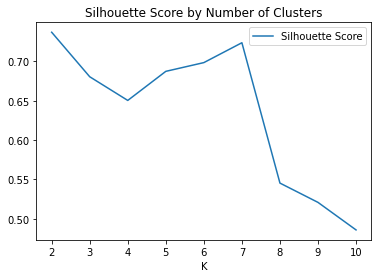

In [70]:
# visualizing the silhouette scores
sns.lineplot(
    x=range(2,11),
    y=silhouette_score,
    label='Silhouette Score'
).set(
    title='Silhouette Score by Number of Clusters',
    xlabel='K')

plt.show()

##### Build the K-Means Clustering model

In [79]:
# create the final model
algo_kmeans = KMeans(featuresCol='standardized', k=3)
model_kmeans = algo_kmeans.fit(data_scale_output)

In [80]:
# assign clusters to the dataset
cluster_assignment = model_kmeans.transform(data_scale_output)

##### Plot the cluster distribution

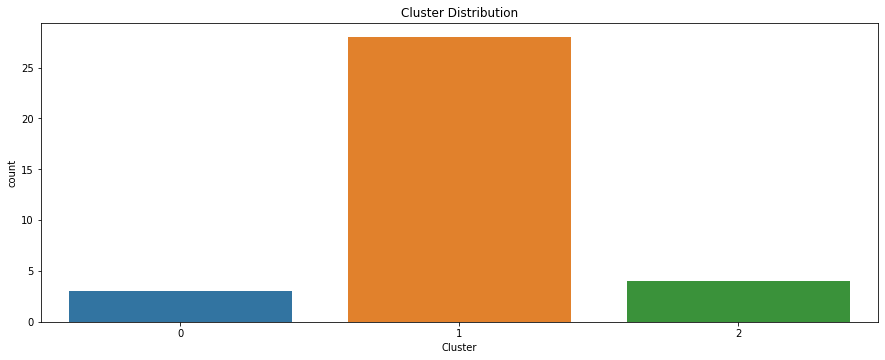

In [81]:
# get the summary dataset to use for plotting
df_cluster_distribution = cluster_assignment \
    .groupby('prediction') \
    .count() \
    .toPandas()

# plot the cluster distribution
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(
    data=df_cluster_distribution,
    x='prediction',
    y='count',
    ax=ax
).set(
    title='Cluster Distribution',
    xlabel='Cluster')

plt.show()

In [82]:
df_evaluate = cluster_assignment.toPandas().sort_values('prediction').drop(['features', 'standardized'], axis=1)
df_evaluate

,IP,vlan,total_bytes,dowload_bytes,upload_bytes,Sunday_avg_bytes,Monday_avg_bytes,Tuesday_avg_bytes,Wednesday_avg_bytes,Thursday_avg_bytes,Friday_avg_bytes,Saturday_avg_bytes,morning_avg_bytes,afternoon_avg_bytes,evening_avg_bytes,night_avg_bytes,prediction
17,192.168.3.126,tenants,46972916478,45211954616,1760961862,4309172.0,4359285.0,3835025.0,3993398.0,3527929.0,3929650.0,3703100.0,4283897.0,3943192.0,3668951.0,3792437.0,0
21,192.168.3.111,tenants,16920034700,16437295084,482739616,774019.0,1807649.0,3865.0,3398069.0,3473479.0,2325885.0,2398593.0,3067.0,2832800.0,4728770.0,12314.0,0
19,192.168.3.124,tenants,3262389558,3138844740,123544818,5142721.0,0.0,2413150.0,5843865.0,0.0,0.0,0.0,0.0,5805724.0,4097320.0,0.0,0
32,192.168.1.11,private,436874067,395806116,41067951,11394.0,11500.0,11121.0,0.0,0.0,12649.0,124765.0,11116.0,11358.0,11681.0,147665.0,1
31,192.168.1.136,private,361938554,354474309,7464245,30.0,74220.0,178670.0,0.0,0.0,7.0,176833.0,254522.0,74.0,1613.0,56781.0,1
30,192.168.1.142,private,6071921750,4343843324,1728078426,1251355.0,505715.0,441797.0,267092.0,208763.0,438136.0,410003.0,272434.0,475706.0,647030.0,419400.0,1
29,192.168.1.156,private,140908,81499,59409,593.0,1773.0,884.0,0.0,973.0,813.0,1530.0,830.0,0.0,0.0,1773.0,1
28,192.168.1.160,private,290209967,166939706,123270261,5195.0,3791.0,8916.0,32113.0,37973.0,7298.0,2893.0,19809.0,22228.0,2941.0,3783.0,1
27,192.168.1.179,private,1548570684,1345976703,202593981,47135.0,67095.0,129004.0,27421.0,332499.0,132008.0,36683.0,41275.0,114499.0,156365.0,47756.0,1
26,192.168.1.185,private,1409029277,1224428145,184601132,0.0,1433847.0,1542670.0,60760.0,28509.0,28334.0,108348.0,19341.0,996480.0,82464.0,1607.0,1
